# ASSIGNMENT 3

**NOME:** Christian

**COGNOME:** Uccheddu

**MATRICOLA:** 800428

> This assignment is based on the code of Prof. Samuel Albani left during the lessons.

First the necessary libraries are imported in which the relative versions are also printed so that everything is reproducible.

In [32]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy import stats
import scipy
import seaborn as sns
import seaborn
from pylab import *
import matplotlib.gridspec as gridspec

import datetime as dtm
from datetime import datetime

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import matplotlib
import cartopy
import xarray as xr

pd.options.mode.chained_assignment = None

print("Pandas version:",pd.__version__)
print("Numpy version:",np.__version__)
print("Cartopy version:",cartopy.__version__)
print("Geoandas version:",gpd.__version__)
print("Matplotlib version:",matplotlib.__version__)
print("Scipy version:",scipy.__version__)
print("Seaborn version:",sns.__version__)
print("Xarray version:",xr.__version__)

Pandas version: 1.2.3
Numpy version: 1.19.2
Cartopy version: 0.18.0
Geoandas version: 0.8.1
Matplotlib version: 3.3.4
Scipy version: 1.6.1
Seaborn version: 0.11.1
Xarray version: 0.17.0


## Import data from assignment 2

I first import the data from assignment 2  without re-running the previous code as that is not the purpose of this exercise. Then I select the time series that goes from 1901 to 2014 to make it comparable with the ensemble model that we will get later.

In [31]:
gmta_2 = pd.read_csv("gmta.csv", sep = ",", index_col=[0])
gmta_2 = gmta_2.loc[(gmta_2['time'] >= "1901") & (gmta_2['time'] <= "2015")]

gmta_2.head()

time      gmta
51  1901-12-31 -0.242510
52  1902-12-31 -0.510430
53  1903-12-31 -0.500922
54  1904-12-31 -0.557091
55  1905-12-31 -0.370764

## Import data for assignment 3

At this point I import the 4 files that contain the three models. In particular, the last model is divided into two files which will then be concatenated to have a single model.

In [4]:
modfile='dati/ts_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc'
modfile2='dati/ts_Amon_MRI-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc'
modfile3='dati/ts_Amon_MIROC6_historical_r1i1p1f1_gn_185001-194912.nc'
modfile4='dati/ts_Amon_MIROC6_historical_r1i1p1f1_gn_195001-201412.nc'

Now I extract the time series that we will need to visualize the data on graphs. I also concatenate the third and fourth time series into a single time series.

In [33]:
d1d = xr.open_dataset(modfile)
ts1 = d1d.ts  

d2d = xr.open_dataset(modfile2)
ts2 = d2d.ts  

d3d = xr.open_dataset(modfile3)
ts3 = d3d.ts  

d4d = xr.open_dataset(modfile4)
ts4 = d4d.ts  

m5 = xr.concat([ts3, ts4], dim = "time")

I make a plot of the means of the three time series so that I can visualize them on a map. In particular they have been colored with the "coolwarm" colormap which gives a good idea of which areas are warmer than others. I leave all three in the same figure using matplotlib's **gridspec** which allows you to define fully customizable grids.

/Users/christianuccheddu/opt/anaconda3/envs/environment/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


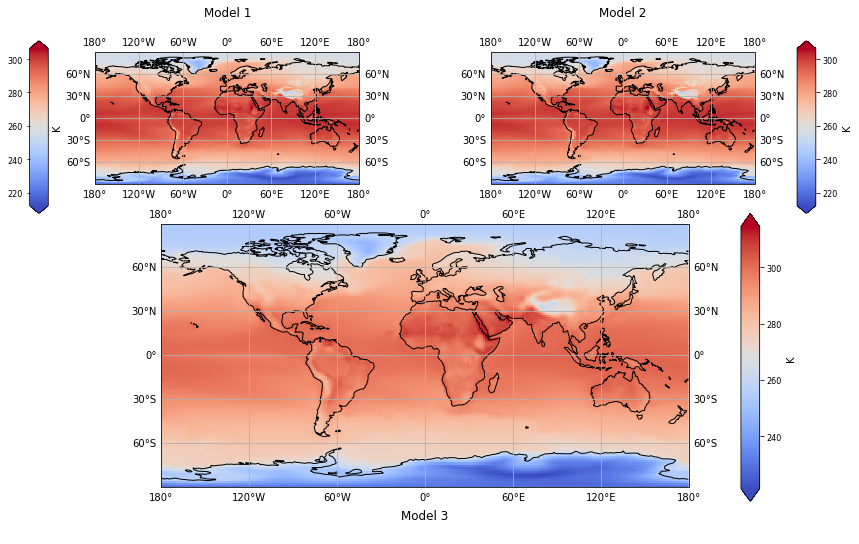

In [34]:
# Define the figure and the grid to fill with the three different plot
fig = plt.figure(figsize=(13,8))
gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[1, 2], hspace = 0.2)

# Define the color map
cmap = mpl.cm.coolwarm

# Plot of the first time series
ax0 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax0.set_title('Model 1\n')
ax0.set_global()
mm0 = ax0.pcolormesh(ts1.lon, ts1.lat, ts1.mean(axis = 0), \
                   transform=ccrs.PlateCarree(),cmap=cmap)  
ax0.coastlines()
ax0.gridlines(draw_labels=True)
cbar_ax0 = fig.add_axes([0.09, 0.6, 0.02, 0.30]) #[left, bottom, width, height]
cbar0 = fig.colorbar(mm0, cax=cbar_ax0, extend='both', orientation='vertical')
cbar0.set_label('K')
cbar0.ax.tick_params(labelsize=8)
cbar_ax0.yaxis.tick_left()

# Plot of the second time series
ax1 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
ax1.set_title('Model 2\n')
ax1.set_global()
mm1 = ax1.pcolormesh(ts1.lon, ts1.lat, ts1.mean(axis = 0), \
                   transform=ccrs.PlateCarree(),cmap=cmap)  
ax1.coastlines()
ax1.gridlines(draw_labels=True)
cbar_ax1 = fig.add_axes([0.91, 0.6, 0.02, 0.30]) #[left, bottom, width, height]
cbar1 = fig.colorbar(mm1, cax=cbar_ax1, extend='both', orientation='vertical')
cbar1.set_label('K')
cbar1.ax.tick_params(labelsize=8)

# Plot of the third time series
ax2 = fig.add_subplot(gs[1:, :], projection=ccrs.PlateCarree())
ax2.set_title("Model 3\n", y=-0.2)
ax2.set_global()
mm2 = ax2.pcolormesh(m5.lon, m5.lat, m5.mean(axis = 0), \
                   transform=ccrs.PlateCarree(),cmap=cmap )  
ax2.coastlines()
ax2.gridlines(draw_labels=True)
cbar_ax2 = fig.add_axes([0.85, 0.1, 0.02, 0.50]) #[left, bottom, width, height]
cbar2 = fig.colorbar(mm2, cax=cbar_ax2, extend='both', orientation='vertical')
cbar2.set_label('K')
cbar2.ax.tick_params(labelsize=8)
plt.tight_layout()
plt.show()

At this point I do the regridding operation bringing all three time series to a single grid in order to create the ensemble model in a simpler way.

In [35]:
ts1_regridded = ts1.copy()
ts2_regridded = ts2.interp(lat=ts1.lat, lon=ts1.lon, method='linear')
ts3_regridded = m5.interp(lat=ts1.lat, lon=ts1.lon, method='linear')

Now I do the exercise in **two different ways** by ultimately comparing the results obtained. The difference between the two methods lies in the fact that in the *first case the reference period for calculating the anomalies was made considering the average of the values of the years between 1961 and 1990.* *In the second method, instead, what is done is to create a monthly series of the anomalies* and then aggregate these values by average to obtain a single value for the year. A priori I expect this second method to be more accurate than the first since the reference temperatures depend on the month and it is no longer a single one.

## Method 1

First, I separately extrapolate the three time series by averaging along the time dimension by aggregating by year. Subsequently I aggregate these three time series spatially (always distinctly) in order to have a single value for each year for each time series.

In [37]:
prova1 = ts1_regridded.groupby('time.year').mean('time')
prova1 = prova1.loc[prova1['year'] >= 1901]

prova2 = ts2_regridded.groupby('time.year').mean('time')
prova2 = prova2.loc[prova2['year'] >= 1901]

prova3 = ts3_regridded.groupby('time.year').mean('time')
prova3 = prova3.loc[prova3['year'] >= 1901]

prova1_ts = prova1.mean(("lon", "lat"))
prova2_ts = prova2.mean(("lon", "lat"))
prova3_ts = prova3.mean(("lon", "lat"))

I then create the time series of the ensemble model by averaging the values of the three models. In particular I use the **nanmean** function that allows you to calculate the average even if there are missing values.

In [38]:
ens_mean = np.nanmean([prova1_ts,prova2_ts,prova3_ts], axis=0)

I now draw the time series of the three models and of the ensemble model to verify that I am getting what I expected.

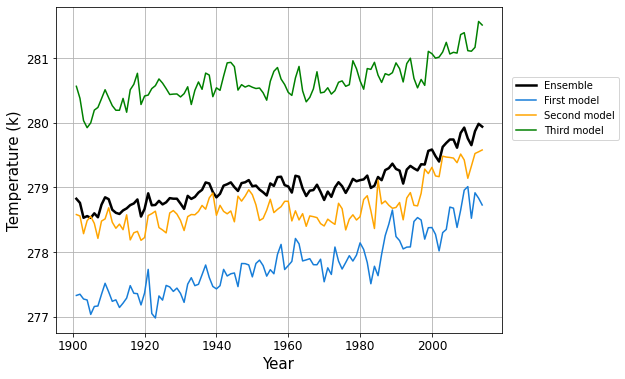

In [144]:
plt.figure(figsize =(8,6))
plt.plot(prova1.year, ens_mean, color = "black", label = "Ensemble", ls = "-", linewidth = 2.5)
plt.plot(prova1.year, prova1_ts, color = "#177DD8", label = "First model", ls = "-")
plt.plot(prova1.year, prova2_ts, color = "orange", label = "Second model", ls = "-")
plt.plot(prova1.year, prova3_ts, color = "green", label = "Third model", ls = "-")

plt.legend(bbox_to_anchor=(1.01, 0.6, 1.1, 0.2), loc='upper left')
plt.xlabel("Year", fontsize = 15)
plt.ylabel("Temperature (k)", fontsize = 15)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.grid()

Now I create the historical series of the models as a dataframe so that we can make the series of anomalies by subtracting the average of the reference period.

In [47]:
ensemble_time = pd.concat([pd.Series(prova1.year, name = "time"), pd.Series(ens_mean, name = "Ensemble mean")], axis = 1, ignore_index = True)
ensemble_time.columns = ['time', 'ensemble mean']
ensemble_time.head()

time  ensemble mean
0  1901     278.824352
1  1902     278.761319
2  1903     278.530859
3  1904     278.556575
4  1905     278.529087

In [48]:
ensemble_ref = ensemble_time - ensemble_time.loc[(ensemble_time['time'] >= 1961) & (ensemble_time['time'] <= 1990)].mean()
ensemble_ref['time'] = ensemble_time['time']
ensemble_ref.head()

time  ensemble mean
0  1901      -0.234605
1  1902      -0.297639
2  1903      -0.528099
3  1904      -0.502382
4  1905      -0.529871

To see if the differences between the means of the two distributions are significant I use a Student's T test on the two time series. The null hypothesis of this test is that the means of the two distributions are statistically equivalent. *If the p-value is less than the reference value 0.05 (therefore with a confidence interval around the 95% average) then the null hypothesis is rejected and the means are statistically different.*
**Since in this case the p-value is 0.09 we can't reject the null hypothesis, so the mean of the two anomaly time series can't be considered statistically different.**

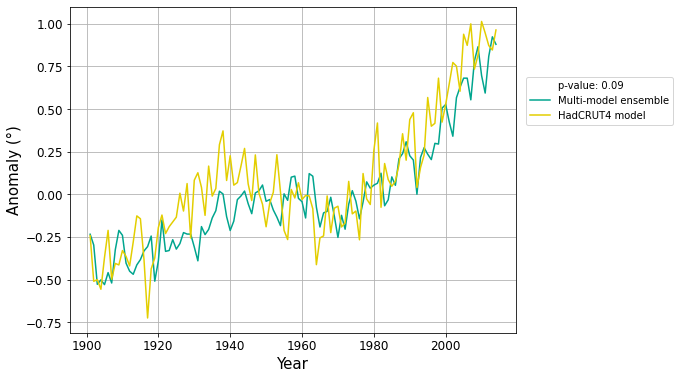

In [117]:
t, p = stats.ttest_ind(ensemble_ref['ensemble mean'], gmta_2['gmta'], equal_var = False)

plt.figure(figsize = (8,6))

p1, = plt.plot(ensemble_ref['time'], ensemble_ref['ensemble mean'], color = "#00A58E", ls = "-")
p2, = plt.plot(ensemble_ref['time'], gmta_2['gmta'], color = "#E3CE00", ls = "-")

extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

plt.legend([extra, p1, p2], ["p-value: {:.1}".format(p), "Multi-model ensemble", "HadCRUT4 model"],
           bbox_to_anchor=(1.01, 0.6, 1.1, 0.2), loc='upper left')
plt.xlabel("Year", fontsize = 15)
plt.ylabel("Anomaly (°)", fontsize = 15)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.grid()

As we can see from the graph, the trend of the two historical series seems to be the same. In particular, it appears to be clearly increasing over time, suggesting that the anomalies calculated by the ensemble model are similar with respect to the anomalies of the HadCRUT4 model. So let's see in the next graph the trend over the years of the difference between these two historical series. If this difference is more or less constant near 0 then our considerations are correct.

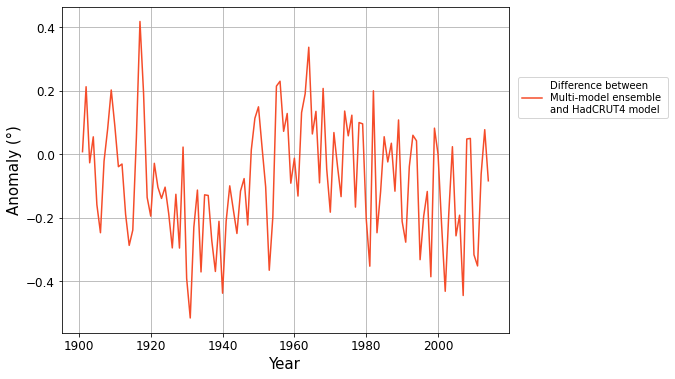

In [148]:
diff_ts = np.array(ensemble_ref['ensemble mean']) - np.array(gmta_2['gmta'])
plt.figure(figsize = (8,6))

p1, = plt.plot(ensemble_ref['time'], diff_ts, color = "#F54C2A", ls = "-")

plt.legend([p1], ["Difference between\nMulti-model ensemble \nand HadCRUT4 model"],
           bbox_to_anchor=(1.01, 0.6, 1.1, 0.2), loc='upper left')
plt.xlabel("Year", fontsize = 15)
plt.ylabel("Anomaly (°)", fontsize = 15)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.grid()

As you can see from the graph, this difference is actually close to 0 and more or less constant, albeit with many fluctuations.

## Method 2

As previously described, we now create the historical series of anomalies no longer having a single reference temperature but having a reference temperature for each month. The steps performed will be very similar to those made for method one with the difference of the time period over which the aggregation takes place. 

In [83]:
ens_mean_month = np.nanmean([ts2_regridded.mean(("lon", "lat")), ts2_regridded.mean(("lon", "lat")), ts3_regridded.mean(("lon", "lat"))], axis=0)

In [84]:
ens_month = pd.concat([pd.Series(ts1_regridded.time, name = "time"), pd.Series(ens_mean_month, name = "Ensemble mean")], axis = 1, ignore_index = True)
ens_month.columns = ['time', 'Ensemble historical']
ens_month['time'] = pd.to_datetime(ens_month['time'], format = "%Y-%m-%d %H:%M:%S")
ens_month = ens_month[ens_month['time'].dt.year >= 1901]
ens_month['year'] = ens_month['time'].dt.year
ens_month['month'] = ens_month['time'].dt.month
ens_month.drop("time", axis = 1, inplace = True)

ens_month.head()

Ensemble historical  year  month
612           278.138099  1901      1
613           277.551341  1901      2
614           277.041044  1901      3
615           278.168644  1901      4
616           279.922747  1901      5

I create the series of reference periods for the calculation of anomalies

In [85]:
ref_month = ens_month.loc[(ens_month['year'] >= 1961) & (ens_month['year'] <= 1990)].groupby("month").mean().reset_index().drop("year", axis = 1)
ref_month.columns = ['month', 'reference temperature']
ref_month

month  reference temperature
0       1             277.920223
1       2             277.372566
2       3             277.159798
3       4             278.166290
4       5             279.941229
5       6             281.396635
6       7             281.885874
7       8             281.417153
8       9             280.286918
9      10             279.129323
10     11             278.395227
11     12             278.270028

I merge the two datasets in order to make the difference with the corresponding month and have the final dataset that contains the historical series of anomalies for each year.

In [86]:
anomaly_month = pd.merge(ens_month, ref_month, on = "month", how = "inner")
anomaly_month['anomaly'] = anomaly_month['Ensemble historical'] - anomaly_month['reference temperature']
anomaly_month = anomaly_month.groupby('year').mean().reset_index()[['year', 'anomaly']]

As a first comparison, this historical series obtained with the one obtained by assignment two, also in this case carrying out a t-student test to see if the means of the two distributions are statistically different.
**Since in this case the p-value is 0.96 we can't reject the null hypothesis, so the mean of the two anomaly time series can't be considered statistically different.**

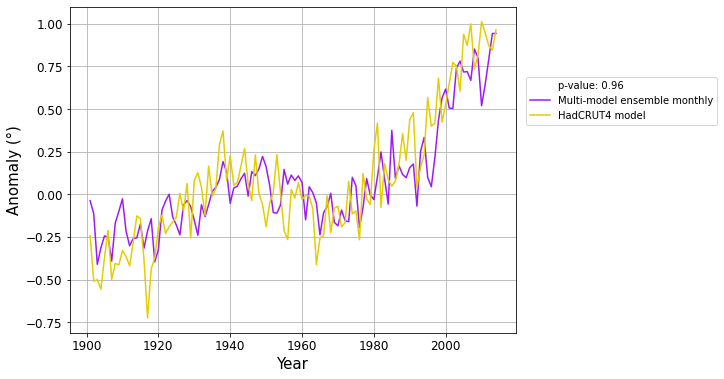

In [111]:
t, p = stats.ttest_ind(anomaly_month['anomaly'], gmta_2['gmta'], equal_var = False)

plt.figure(figsize = (8,6))

p1, = plt.plot(anomaly_month['year'], anomaly_month['anomaly'], color = "#9D1AF4", ls = "-")
p2, = plt.plot(anomaly_month['year'], gmta_2['gmta'], color = "#E3CE00", ls = "-")

extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

plt.legend([extra, p1, p2], ["p-value: {:.2}".format(p), "Multi-model ensemble monthly", "HadCRUT4 model"],
           bbox_to_anchor=(1.01, 0.6, 1.1, 0.2), loc='upper left')
plt.xlabel("Year", fontsize = 15)
plt.ylabel("Anomaly (°)", fontsize = 15)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.grid()

As can be seen from the graph, this series seems to be more similar to the HadCRUT4 model than the previous one both in terms of trend and in terms of average deviation. As we have done before let's see in the next graph the trend over the years of the difference between these two historical series. If this difference is more or less constant near 0 then our considerations are correct.

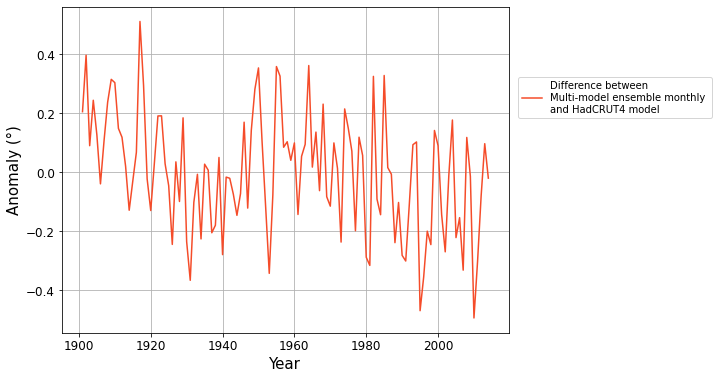

In [149]:
diff_ts_month = np.array(anomaly_month['anomaly']) - np.array(gmta_2['gmta']) 
plt.figure(figsize = (8,6))

p1, = plt.plot(ensemble_ref['time'], diff_ts_month, color = "#F54C2A", ls = "-")

plt.legend([p1], ["Difference between\nMulti-model ensemble monthly \nand HadCRUT4 model"],
           bbox_to_anchor=(1.01, 0.6, 1.1, 0.2), loc='upper left')
plt.xlabel("Year", fontsize = 15)
plt.ylabel("Anomaly (°)", fontsize = 15)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.grid()

Below we propose the comparison on the same graph between all three models.

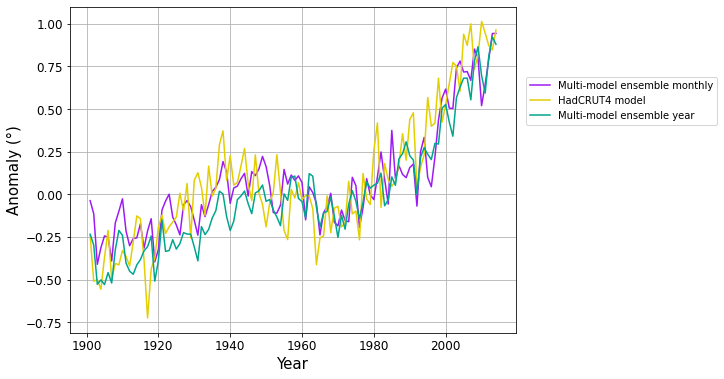

In [116]:
plt.figure(figsize = (8,6))

p1, = plt.plot(anomaly_month['year'], anomaly_month['anomaly'], color = "#9D1AF4", ls = "-")
p2, = plt.plot(anomaly_month['year'], gmta_2['gmta'], color = "#E3CE00", ls = "-")
p3, = plt.plot(anomaly_month['year'], ensemble_ref['ensemble mean'], color = "#00A58E", ls = "-")


plt.legend([p1, p2, p3], [ "Multi-model ensemble monthly", "HadCRUT4 model", "Multi-model ensemble year"],
           bbox_to_anchor=(1.01, 0.6, 1.1, 0.2), loc='upper left')
plt.xlabel("Year", fontsize = 15)
plt.ylabel("Anomaly (°)", fontsize = 15)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.grid()